In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pylab as plt
from datetime import timezone
import json

pd.set_option('display.max_colwidth', -1)

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn import preprocessing

In [3]:
import arango
from arango import ArangoClient
from arango.response import Response
from arango.http import HTTPClient

### Funciones auxiliares

In [4]:
def read_arango_to_pandas(db, collection):
    """
    read an ArangoDB collection and pandas
    
    :param: db - Arango collection    
    :param: collection - Calection to retrieve
    """

    col = db.collection(collection)
    return pd.DataFrame(list(col))

In [5]:
from functools import wraps
import time

def timing(f):
    @wraps(f)
    def wrapper(*args, **kwargs):
        start = time.time()
        result = f(*args, **kwargs)
        end = time.time()
        print('Elapsed time: {}'.format(end-start))
        return result
    return wrapper

In [6]:
import logging

from requests.adapters import HTTPAdapter
from requests import Session

from arango.response import Response
from arango.http import HTTPClient


class CustomHTTPClient(HTTPClient):
    """My custom HTTP client with cool features."""

    def __init__(self):
        self._session = Session()
        # Initialize your logger.
        self._logger = logging.getLogger('my_logger')

    def create_session(self, host):
        session = Session()

        # Add request header.
        session.headers.update({'x-my-header': 'true'})

        # Enable retries.
        adapter = HTTPAdapter(max_retries=5)
        self._session.mount('https://', adapter)

        return session

    def send_request(self,
                     session,
                     method,
                     url,
                     params=None,
                     data=None,
                     headers=None,
                     auth=None):
        # Add your own debug statement.
        self._logger.debug('Sending request to {}'.format(url))

        # Send a request.
        response = session.request(
            method=method,
            url=url,
            params=params,
            data=data,
            headers=headers,
            auth=auth,
            verify=False  # Disable SSL verification
        )
        self._logger.debug('Got {}'.format(response.status_code))

        # Return an instance of arango.response.Response.
        return Response(
            method=response.request.method,
            url=response.url,
            headers=response.headers,
            status_code=response.status_code,
            status_text=response.reason,
            raw_body=response.text,
        )

In [7]:
@timing
def execute(query):
    cursor = aql.execute(query)
    item_keys = [doc for doc in cursor]
    return item_keys

## Data: relaciones A $\to$ B documentales

In [8]:
# Tunel local de Yessika 
client = ArangoClient(hosts='http://XX.XX.X.XX:XXXX', http_client=CustomHTTPClient())
db = client.db('gp', username='root', password='openSesame')
aql = db.aql
pregel = db.pregel

#-------------------------------------------------------------
# PRUEBA DE CONEXION - Nº de documentos

collection = 'documents_NER'
query=r'''RETURN LENGTH(''' + collection + ''')'''
print(query)
execute(query)

RETURN LENGTH(documents_NER)
Elapsed time: 0.114410400390625


[745]

In [41]:
#get NER collection
col = db.collection('documents_NER')
pd_documents_ner = pd.DataFrame(list(col))
print(pd_documents_ner.shape)
pd_documents_ner.head(1)

(1830, 13)


,_key,_id,_rev,id_document,doc_extraction,master_extraction,key_master,type_ner,created,updated,uploader,key_job_company,dateIngested
0,documents-76d3d678-8ec1-4979-b299-8019b19750c5_orgsMaster-1573068564-122993522,documents_NER/documents-76d3d678-8ec1-4979-b299-8019b19750c5_orgsMaster-1573068564-122993522,_ZipHs-W---,documents/76d3d678-8ec1-4979-b299-8019b19750c5,company,accompany,orgsMaster/1573068564-122993522,org,2016-12-26T00:17:07.000Z,2016-12-26T00:17:07.536Z,ndave,,2019-11-08T11:32:44.144Z


In [42]:
#limpia el dataframe
pd_documents_ner = pd_documents_ner[["id_document", "doc_extraction", "master_extraction", "type_ner", "updated", "uploader", "key_job_company"]]
pd_documents_ner.columns = ["id_doc", "ner_entity", "master_entity", "ner_type", "date", "doc_uploader", "key_job_company"]
pd_documents_ner['date'] = pd_documents_ner.date.apply(lambda x: str(x)[0:10])
pd_documents_ner['id_doc'] = pd_documents_ner['id_doc'].apply(lambda x: str(x).replace('documents/',''))
pd_documents_ner['key_job_company'] = pd_documents_ner['key_job_company'].apply(lambda x: str(x).replace('orgsMaster/',''))
pd_documents_ner.head(1)

,id_doc,ner_entity,master_entity,ner_type,date,doc_uploader,key_job_company
0,76d3d678-8ec1-4979-b299-8019b19750c5,company,accompany,org,2016-12-26,ndave,


In [43]:
#numero entidades por documento:
pd_documents_ner['id_doc'].value_counts()

00d68b2f-7466-4405-9562-0ef7ea391a01    100
00f16a6d-4543-405f-a0c7-bb6da54935a4    94 
00cb122d-5b00-420b-9f91-874c7d553b6c    93 
012039ee-b0bc-4693-bb28-e62bb282b743    91 
00f2c626-141e-4478-a2d2-ebddd4354df1    73 
                                        .. 
00c7f3a6-63f9-4525-8269-f056892e35d0    1  
00e9bf7b-ebbe-4e4e-8775-88fe9ca906a0    1  
002c4b68-6da5-444f-81ff-c9567b0ad3bf    1  
00729703-6b4a-47a4-8eba-3d430be588be    1  
00c70508-c7eb-4fe9-ad62-4288b36b7856    1  
Name: id_doc, Length: 101, dtype: int64

In [44]:
#tipos de entidades reconocidas por NER:
pd_documents_ner.ner_type.unique()

array(['org', 'person'], dtype=object)

In [45]:
pd_ner_person = pd_documents_ner[pd_documents_ner.ner_type == 'person']

In [46]:
#numero de personas reconocidas por documento:
pd_ner_person['id_doc'].value_counts()

00d68b2f-7466-4405-9562-0ef7ea391a01    30
00cb122d-5b00-420b-9f91-874c7d553b6c    27
0002890d-a244-44a5-ae58-d54b4c8caf29    26
00e2ea53-461d-430e-b23a-038ad153dc21    26
00c94c03-f547-42f2-82ec-af4a5af98042    21
00f2c626-141e-4478-a2d2-ebddd4354df1    21
00c81ad1-489d-40f3-b742-386773a30b86    19
012039ee-b0bc-4693-bb28-e62bb282b743    15
004de596-295a-4409-8511-ea40ab8331d9    14
00fa6221-85f8-4ba2-b2c8-273260e382df    10
0002c246-92fe-4a26-a284-d64f7066e038    9 
012ca8ad-0940-428f-909b-51e9e58252a5    8 
00f16a6d-4543-405f-a0c7-bb6da54935a4    8 
00494a2e-fc6c-411f-8fc9-e19008d0c83c    6 
005be05f-26fb-442d-afe6-d7747715bd7b    6 
0049aaa5-77ac-4a70-9c59-5b41632c5678    3 
011b954f-879c-405a-b477-59e78f72dfde    3 
01087a59-c968-43a4-8f3f-51515bd4aba9    2 
00a9bfc6-a5f0-42dc-a6c2-3874371a8752    2 
00a51ee2-d525-410b-b46d-6956f610f83d    2 
0125780e-1d9a-442d-988b-4d39cc5ab203    2 
008b7025-e64c-4d2d-abd7-22fb988d5f7d    2 
00a3d562-215c-4505-8f3d-e585af6580c7    2 
010b93d2-cf

In [50]:
pd_ner_person[pd_ner_person['id_doc'] == '00f16a6d-4543-405f-a0c7-bb6da54935a4']

,id_doc,ner_entity,master_entity,ner_type,date,doc_uploader,key_job_company
1400,00f16a6d-4543-405f-a0c7-bb6da54935a4,larizadeh duggan,avid larizadeh duggan,person,2019-08-22,__del__220__carl.elfving,1573056623-122450453
1401,00f16a6d-4543-405f-a0c7-bb6da54935a4,sam nurmi,sam nurmi,person,2019-08-22,__del__220__carl.elfving,1573061301-134878036
1402,00f16a6d-4543-405f-a0c7-bb6da54935a4,johan roslund,johan roslund,person,2019-08-22,__del__220__carl.elfving,1573064376-27422297
1420,00f16a6d-4543-405f-a0c7-bb6da54935a4,satya nadella,satya nadella,person,2019-08-22,__del__220__carl.elfving,1573079019-37843220
1423,00f16a6d-4543-405f-a0c7-bb6da54935a4,felix bratell,mr felix bratell,person,2019-08-22,__del__220__carl.elfving,1573064376-27422297
1425,00f16a6d-4543-405f-a0c7-bb6da54935a4,andreas liffgarden,andreas liffgarden,person,2019-08-22,__del__220__carl.elfving,1573056119-74906496
1428,00f16a6d-4543-405f-a0c7-bb6da54935a4,tom hall,tom hall,person,2019-08-22,__del__220__carl.elfving,1573056119-127499038
1429,00f16a6d-4543-405f-a0c7-bb6da54935a4,johan roslund,johan roslund,person,2019-08-22,__del__220__carl.elfving,1573081538-5272434


## Cálculo de pesos

In [ ]:
pd_ner_person = pd_documents_ner[pd_documents_ner.ner_type == 'person']


In [10]:
alpha = 0.5
q = 1.6
p = 1
factor = 10**7

#min-max scaler
scaler = preprocessing.MinMaxScaler()

#current utc timestamp
t0 = time.time()/factor

pd_sent = pd_master[pd_master.type == 'sent']
    
#set timezone of datetime object to utc and calculates the timestamp
pd_sent['t'] = pd.to_datetime(pd_sent.date).apply(lambda x: x.replace(tzinfo=timezone.utc).timestamp()/factor)
#weight is decreasing with time
pd_sent['t-t0'] = pd_sent['t'] - t0
pd_sent['weight'] = q * np.exp( alpha * pd_sent['t-t0'] )
#sum over interaction pairs
final = pd_sent[['from', 'to', 'weight']].groupby(['from', 'to']).sum().reset_index()
#apply log-transformation to compensate for highly interecting people
final['weight'] = np.log1p( final['weight'] )
#scale to be a number in range [0,1] and return the complement 
final['weight'] = (1 - scaler.fit_transform(final['weight'].values.reshape(-1,1)))


In [11]:
[final.weight.min(), final.weight.max()]

[0.0, 1.0]

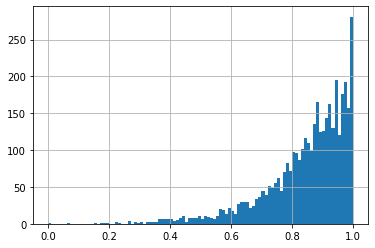

In [12]:
final.weight.hist(bins=100)